Розглянемо таку задачу. Маємо набір даних про цифри, а саме їх зображення.  
Потрібно навчити нейронну мережу класифікувати зображення цифр.

Почнемо з небхідних імпортів та налаштувань середовища.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

sns.set()

Using TensorFlow backend.


Загружаємо дані про цифри.

In [2]:
digits = load_digits()
X = digits.data
y = digits.target

Проведемо невеликий розвідувальний аналіз даних.

In [3]:
print(X)
print("unique values of X =", np.unique(X))
print("shape of X =", X.shape)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
unique values of X = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
shape of X = (1797, 64)


Бачимо, що матриця ознак $X$ має форму  $1797\times64$  та кожний елемент матриці примає  
цілі значення від $0$ до $16$. Під цим мається на увазі, що зображення кожної цифри  
є картинкою $8\times8$ пікселів та колір цього пікселя виражається у мірі сірого від $0$ до $16$,  
тобто $0$ $-$ білий, а $16$ $-$ чорний. $1797$ є числом спостережень, тобто навчальних картинок.  

In [4]:
print("y =", y)
print("unique values of y =", np.unique(y))
print("shape of y =", y.shape)

y = [0 1 2 ... 8 9 8]
unique values of y = [0 1 2 3 4 5 6 7 8 9]
shape of y = (1797,)


Тут бачимо, що цільовий вектор складається з цифр та має складається з $1797$ елементів. Це логічно,  
оскільки кожному спостереженню (рядку матриці $X$) має відповідати єдине число масиву $y$.  
$i$-тому рядку $X$ відповідає $i$-й елемент $y$.

Тепер можемо зобразити декілька екземплярів цифр із вибірки. Щоб не мати сумніву з приводу  
класу зображеної цифри, в лівому нижньому куту зробимо помітку класу.

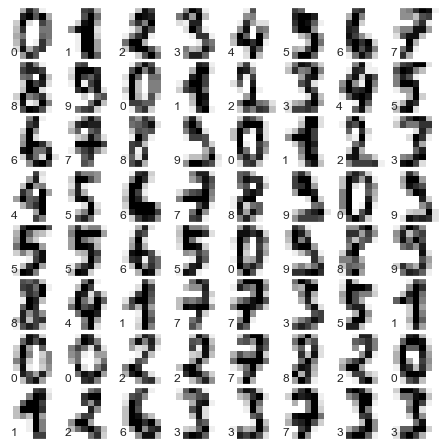

In [5]:
fig, ax = plt.subplots(8, 8,
                       figsize=(6, 6),
                       subplot_kw=dict(xticks=[],
                                       yticks=[]),
                       gridspec_kw=dict(left=0,
                                        right=1,
                                        bottom=0,
                                        top=1,
                                        hspace=0.05,
                                        wspace=0.05))
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i].reshape(8, 8), cmap=plt.cm.binary, interpolation='nearest')
    axi.text(0, 7, str(digits.target[i]))

Перш ніж починати обробку, розділимо дані на тренувальні та тестувальні у відношенні $80/20$ відповідно.  
Це потрібно для того, щоб адекватно оцінити роботу класифікатора за допомогую прогнозування на "невідомих" йому даних.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

Також необхідно трансформувати цільовий вектор $y$ в матрицю з одним активним станом,  
який є ідентифікатором класу. Тобто матимемо матрицю із десятьма стовпчиками. 

In [7]:
y_train_onehot = pd.get_dummies(y_train)
y_test_onehot = pd.get_dummies(y_test)

print(y_train_onehot.values)
print("y_train shape become", y_train_onehot.shape)
print(y_test_onehot.values)
print("y_test shape become", y_test_onehot.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]]
y_train shape become (1437, 10)
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]
y_test shape become (360, 10)


Хоча вже можна починати будувати модель нейронної мережі, проведемо деяку оптимізацію на її розмір.  
Неважно зрозуміти, що частина даних (пікселів) у зображеннях не є інформативною. Наприклад, майже   
всі кутові пікселі білого кольору, а центральні $-$ сірого. Тому можна відфільтрувати непотрібні дані,  
які не несуть жодної користі для класифікації. Просто прибрати пікселі, які на всіх зображеннях однотипні,  
було б дуже примітивно та не ефективно. Для такого роду задач використовують аналіз головних компонент  
PCA $-$ популярний алгоритм пониження розмірності даних. Якщо розглядати кожне зображення як точку  
в $64$-мірному просторі, то можна казати про базис цього простору. В простому випадку він є класичним $-$ $64$   
вектора із однією  одиничною та іншими нульовими компонентами. Проте PCA дозволяє утворити новий базис із  
векторів меншої за $64$ кількості так, щоб мінімізувати втрату інформації. Метод дає інформацію про частку  
поясненої дисперсії даних $-$ міру того, скільки у відсотках залишається варіації в даних при зменшенні  
кількості векторів базису.  

Побудуємо криву, яка для навчальних даних зобразить кумулятивну (відносно кількості  
компонент, в порядку від "найважливішої" до "безкорисної" компоненти) пояснену дисперсію.  

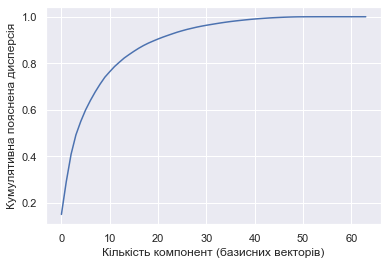

In [8]:
test_pca = PCA(random_state=0).fit(X_train)
variance = np.cumsum(test_pca.explained_variance_ratio_)

fig, ax = plt.subplots()
ax.plot(variance)
ax.set_xlabel('Кількість компонент (базисних векторів)')
ax.set_ylabel('Кумулятивна пояснена дисперсія');

Бачимо, що дані дуже гарно лінійно розділяються (тільки для таких PCA є ефективним).   
Навіть при переході від $64$ до $10$ компонент зберігається майже $80\%$ дисперсії!

Встановимо, скільки саме компонент потрібно взяти для збереження $99\%$ дисперсії.  

In [9]:
pca = PCA(0.99, random_state=0).fit(X_train)
n_components = pca.n_components_
n_components

41

Маємо розмірність $41$. Вважаю, що досить непоганий результат.

In [10]:
pca.components_.shape

(41, 64)

Тепер матриця базису має розмірність $41\times64$, де базисні вектори розташовані по рядках.

Цікаво також подивитись на вигляд самих базисних векторів. По суті, кожен такий вектор також є  
зображенням $8\times8$. Його можна інтерпретувати наступним чином: кожний вектор базису є типовим  
"шаблоном" загальної структури даних. Наприклад, в першому рядку другому стовпчику можна  
розгледіти образ нуля, а правіше $-$ двійки. Грубо кажучи, лінійною комбінацію таких зображень  
можна досить точно відновити довільний елемент тренувальної вибірки.

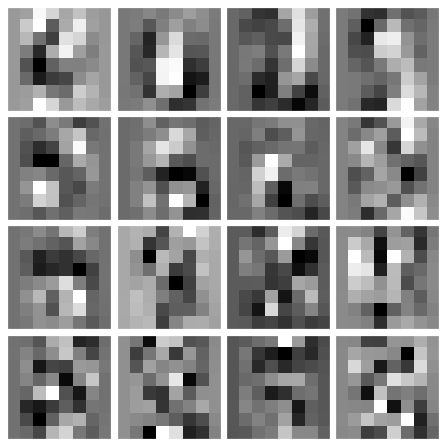

In [11]:
fig, ax = plt.subplots(4, 4,
                       figsize=(6, 6),
                       subplot_kw=dict(xticks=[],
                                       yticks=[]),
                       gridspec_kw=dict(left=0,
                                        right=1,
                                        bottom=0,
                                        top=1,
                                        hspace=0.05,
                                        wspace=0.05))
for i, axi in enumerate(ax.flat):
    axi.imshow(pca.components_[i].reshape(8, 8), cmap=plt.cm.binary, interpolation='nearest')

Для наочності порівняємо оригінал та нове зображення декількох екземплярів.

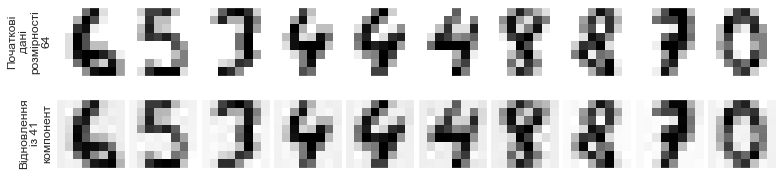

In [12]:
fig, axes = plt.subplots(2,
                         10,
                         figsize=(10, 2.5),
                         subplot_kw=dict(xticks=[], 
                                         yticks=[]),
                         gridspec_kw=dict(left=0,
                                         right=1,
                                         bottom=0,
                                         top=1,
                                         hspace=0.05,
                                         wspace=0.05))
components = pca.transform(X_train)
projected = pca.inverse_transform(components)

for i in range(10):
    axes[0, i].imshow(X_train[i].reshape(8, 8), cmap=plt.cm.binary, interpolation='nearest')
    axes[1, i].imshow(projected[i].reshape(8, 8), cmap=plt.cm.binary, interpolation='nearest')
axes[0, 0].set_ylabel(f'Початкові\nдані\nрозмірності\n{X_train.shape[1]}')
axes[1, 0].set_ylabel(f'Відновлення\nіз {n_components}\nкомпонент');

Переконались, що дані зазнали мінімальних модифікацій.

Наразі ми тільки натренували PCA на тренувальних (!!!) даних, а тепер застосуємо  
трансформацію до тренувальних і тестових.

In [13]:
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)
X_train_reduced.shape, X_test_reduced.shape

((1437, 41), (360, 41))

Тепер вже перейдемо до проектування мережі. Вона матиме тип прямого розповсюдження. Вхідний шар  
складатиметься із $41$ нейрона, а вихідний $-$ із $10$, бо стільки класів. В проміжній частині буде $2$ шари,  
обидва складатимуться із $16$ нейронів. Функція активації останнього шару буде softmax, характерна   
для класифікації. Між всіма іншими шарами використаємо ReLU. Оптимізатором буде стохастичной  
градієнтний спуск із інтенсивністю навчання $0.01$ та її зменшенням на $10^{-5}$ на кожному кроці.  
Функцією втрат буде перехресна ентропія для типу задач класифікації. Для того, щоб оцінити точність  
прогнозування не тільки за втратами, які не зовсім легко інтерпретувати, будемо використовувати  
точність прогнозування $-$ відношення кількості правильно зроблених прогнозів до загальної їх кількості. 

In [14]:
def create_network(input_dim):
    def inner():
        network = Sequential()
        
        network.add(Dense(units=16,
                          activation='relu',
                          input_shape=(input_dim,)))
        network.add(Dense(units=16,
                          activation='relu'))
        network.add(Dense(units=10,
                          activation='softmax'))
        
        sgd = SGD(lr=0.01, decay=10**-5)

        network.compile(loss='categorical_crossentropy',
                        optimizer=sgd,
                        metrics=['accuracy'])
        return network
    return inner

Задамо критерій зупинки навчання. На кожному корці спуску для тестової вибірки буде  
підраховано втрати. Якщо протягом $10$ поколінь втрати не будуть зменшуватись, то  
зупиняємо навчання, а вектор параметрів обираємо із "найкращого" покоління. Тут  
також задаємо дельта $0.0001$ $-$ мінімальна потробна абсолютна зміна втрат, щоб  
визнати нове покоління "кращим" чи "гіршим" за попереднє.

In [15]:
early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=10, 
                               min_delta=0.0001,
                               restore_best_weights=True,
                               verbose=1)

checkpoint = ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

callbacks = [early_stopping, checkpoint]

Відповідно до загальних рекомендацій спеціалістів візьмемо розмір пакету $32$.

In [16]:
network = KerasClassifier(build_fn=create_network(n_components), 
                          epochs=999999,
                          batch_size=32,
                          validation_data=[X_test_reduced, y_test_onehot],
                          callbacks=callbacks,
                          verbose=1)

Виконуємо навчання моделі класифікатора за тренувальною вибіркою.

In [17]:
history = network.fit(X_train_reduced, y_train_onehot);

Train on 1437 samples, validate on 360 samples
Epoch 1/999999
1437/1437 [==============================] - 0s 110us/step - loss: 2.3678 - accuracy: 0.2951 - val_loss: 1.5825 - val_accuracy: 0.4444

Epoch 00001: val_loss improved from inf to 1.58247, saving model to best_model.h5
Epoch 2/999999
1437/1437 [==============================] - 0s 42us/step - loss: 1.2857 - accuracy: 0.5602 - val_loss: 1.1229 - val_accuracy: 0.6250

Epoch 00002: val_loss improved from 1.58247 to 1.12286, saving model to best_model.h5
Epoch 3/999999
1437/1437 [==============================] - 0s 39us/step - loss: 0.9547 - accuracy: 0.6855 - val_loss: 0.8971 - val_accuracy: 0.7194

Epoch 00003: val_loss improved from 1.12286 to 0.89708, saving model to best_model.h5
Epoch 4/999999
1437/1437 [==============================] - 0s 39us/step - loss: 0.7549 - accuracy: 0.7620 - val_loss: 0.7478 - val_accuracy: 0.7806

Epoch 00004: val_loss improved from 0.89708 to 0.74778, saving model to best_model.h5
Epoch 5/9999

1437/1437 [==============================] - 0s 37us/step - loss: 0.0466 - accuracy: 0.9910 - val_loss: 0.1795 - val_accuracy: 0.9500

Epoch 00035: val_loss improved from 0.18143 to 0.17947, saving model to best_model.h5
Epoch 36/999999
1437/1437 [==============================] - 0s 42us/step - loss: 0.0445 - accuracy: 0.9903 - val_loss: 0.1787 - val_accuracy: 0.9528

Epoch 00036: val_loss improved from 0.17947 to 0.17875, saving model to best_model.h5
Epoch 37/999999
1437/1437 [==============================] - 0s 37us/step - loss: 0.0427 - accuracy: 0.9910 - val_loss: 0.1780 - val_accuracy: 0.9556

Epoch 00037: val_loss improved from 0.17875 to 0.17805, saving model to best_model.h5
Epoch 38/999999
1437/1437 [==============================] - 0s 43us/step - loss: 0.0410 - accuracy: 0.9923 - val_loss: 0.1765 - val_accuracy: 0.9556

Epoch 00038: val_loss improved from 0.17805 to 0.17654, saving model to best_model.h5
Epoch 39/999999
1437/1437 [==============================] - 0s 38us

1437/1437 [==============================] - 0s 35us/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.1627 - val_accuracy: 0.9583

Epoch 00071: val_loss did not improve from 0.16262
Epoch 72/999999
1437/1437 [==============================] - 0s 40us/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.1626 - val_accuracy: 0.9583

Epoch 00072: val_loss improved from 0.16262 to 0.16256, saving model to best_model.h5
Epoch 73/999999
1437/1437 [==============================] - 0s 45us/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.1622 - val_accuracy: 0.9583

Epoch 00073: val_loss improved from 0.16256 to 0.16224, saving model to best_model.h5
Epoch 74/999999
1437/1437 [==============================] - 0s 38us/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.1623 - val_accuracy: 0.9583

Epoch 00074: val_loss did not improve from 0.16224
Epoch 75/999999
1437/1437 [==============================] - 0s 42us/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.1624 - val_accur

Вище можна бачити ітеративний опис навчання.

Нарешті, подивимось на точність класифікації. Побудуємо два графіки. Перший буде відношенням  
між поколінням та втратами, при чому окремо для тренувальної та тестувальної вибірки.  
Другий графік побудовано аналогічно, тільки по вісі ординат відзначимо оцінку точності.

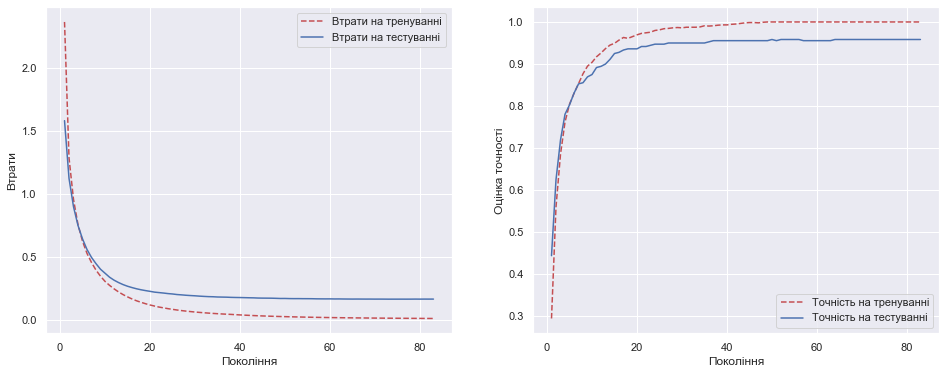

In [18]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
epoch_count = range(1, len(training_loss) + 1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(epoch_count, training_loss, 'r--', label='Втрати на тренуванні')
ax[0].plot(epoch_count, test_loss, 'b-', label='Втрати на тестуванні')
ax[0].set_xlabel('Покоління')
ax[0].set_ylabel('Втрати')
ax[0].legend()

ax[1].plot(epoch_count, training_accuracy, 'r--', label='Точність на тренуванні')
ax[1].plot(epoch_count, test_accuracy, 'b-', label='Точність на тестуванні')
ax[1].set_xlabel('Покоління')
ax[1].set_ylabel('Оцінка точності')
ax[1].legend();

Кожного запуску скриптів модель навчається по різному через стохастичність багатьох процесів.  
Я виявив, що в середньому точність прогнозування знаходиться в околі $95\%$.   
Точні цифри для даного запуску програми наведені нижче.

In [19]:
epoch_cnt = len(test_loss)
print("total count of epochs", epoch_cnt)

best_epoch = epoch_cnt - 10
print(f"best epoch at {best_epoch}th step")

score = test_accuracy[best_epoch]
print(f"accuracy = {np.round(score, 3)} %")

loss = test_loss[best_epoch]
print(f"loss = {np.round(loss, 3)}")

total count of epochs 83
best epoch at 73th step
accuracy = 0.958 %
loss = 0.162
